In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.2.0+cpu


In [2]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [3]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [5]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [6]:
## lets see what is y (i.e the classes assigned)
print(data.y)

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


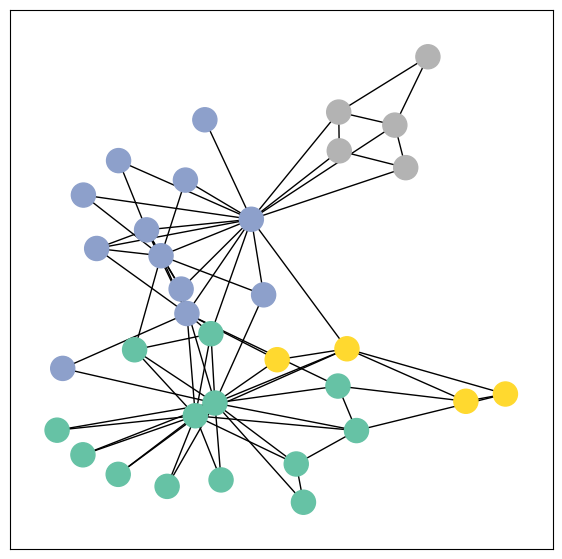

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [21]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN_tanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model_tanh = GCN_tanh()
print(model_tanh)

GCN_tanh(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]
tensor([[-0.1800,  0.6862,  0.1598,  0.1413],
        [-0.1946,  0.6587,  0.1327,  0.1069],
        [-0.1860,  0.6638,  0.1398,  0.1144],
        [-0.1890,  0.6638,  0.1388,  0.1139],
        [-0.1999,  0.6750,  0.1442,  0.1249],
        [-0.1905,  0.6825,  0.1533,  0.1351],
        [-0.1895,  0.6814,  0.1528,  0.1341],
        [-0.1931,  0.6610,  0.1351,  0.1099],
        [-0.1940,  0.6523,  0.1278,  0.0997],
        [-0.1952,  0.6484,  0.1243,  0.0950],
        [-0.1975,  0.6764,  0.1460,  0.1269],
        [-0.1836,  0.6835,  0.1564,  0.1375],
        [-0.1935,  0.6638,  0.1372,  0.1130],
        [-0.1913,  0.6574,  0.1328,  0.1060],
        [-0.2014,  0.6454,  0.1198,  0.0904],
        [-0.1991,  0.6445,  0.1198,  0.0898],
        [-0.1890,  0.6801,  0.1518,  0.1326],
        [-0.2028,  0.6605,  0.1315,  0.1076],
        [-0.1974,  0.6422,  0.1186,  0.0874],
        [-0.1994,  0.6531,  0.1267,  0.0997],
        [-0.1955,  0.6516,  0.1268,  0.0986],
        [

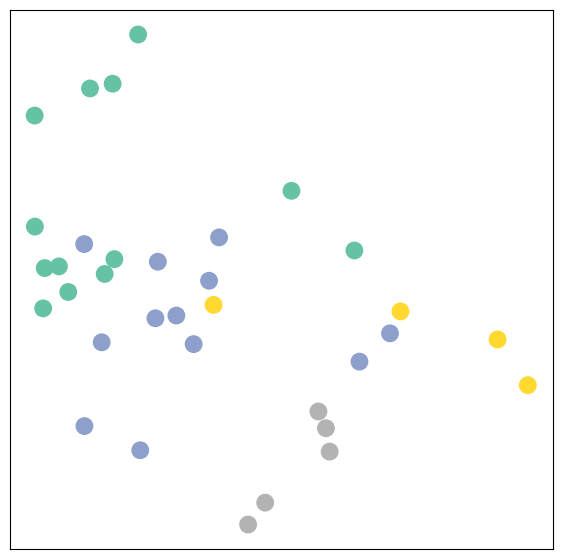

In [22]:
model_tanh = GCN_tanh()

out, h = model_tanh(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
print(out)

visualize_embedding(h, color=data.y)

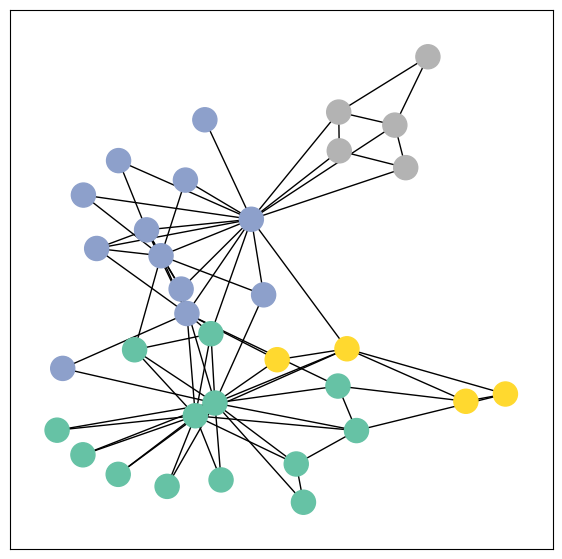

In [23]:
visualize_graph(G, color=data.y)

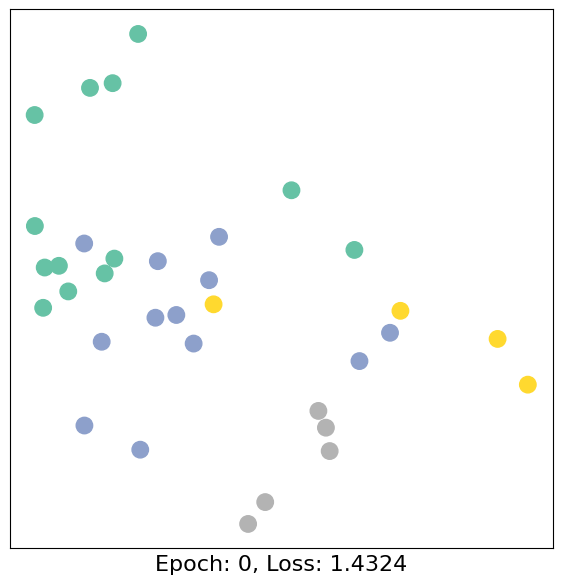

0 tensor(1.4324, grad_fn=<NllLossBackward0>)


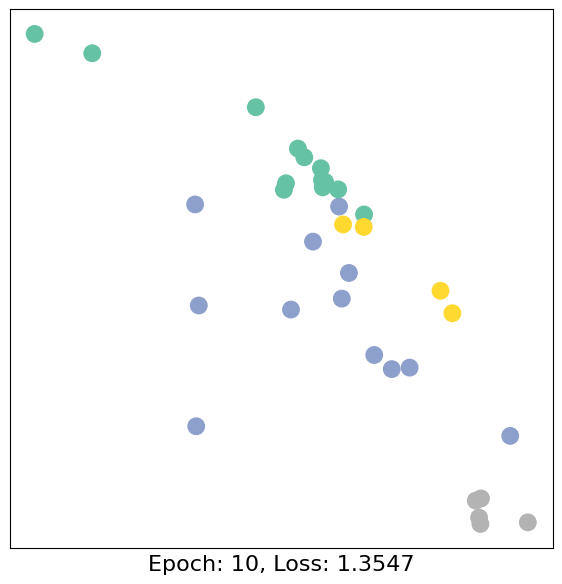

10 tensor(1.3547, grad_fn=<NllLossBackward0>)


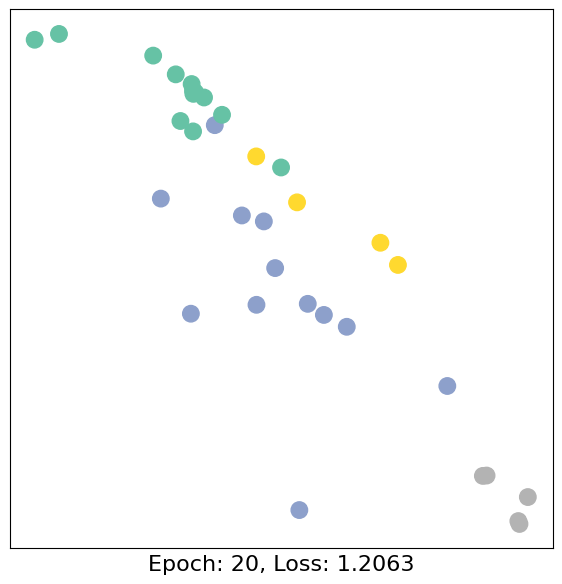

20 tensor(1.2063, grad_fn=<NllLossBackward0>)


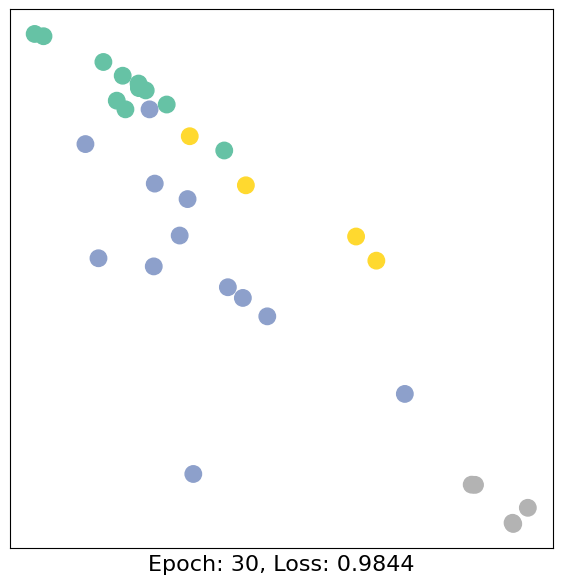

30 tensor(0.9844, grad_fn=<NllLossBackward0>)


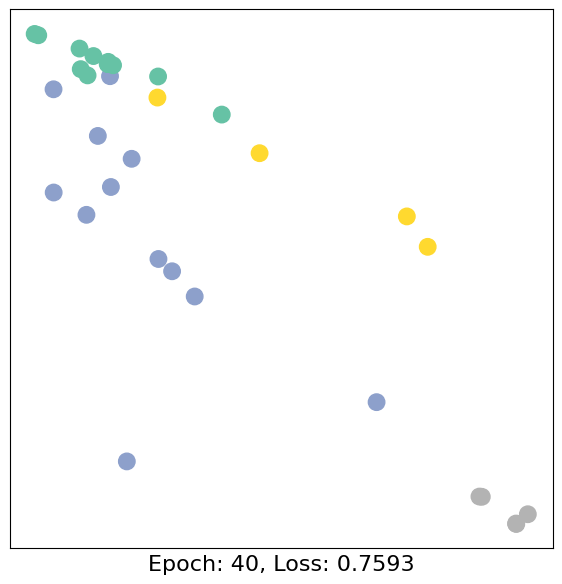

40 tensor(0.7593, grad_fn=<NllLossBackward0>)


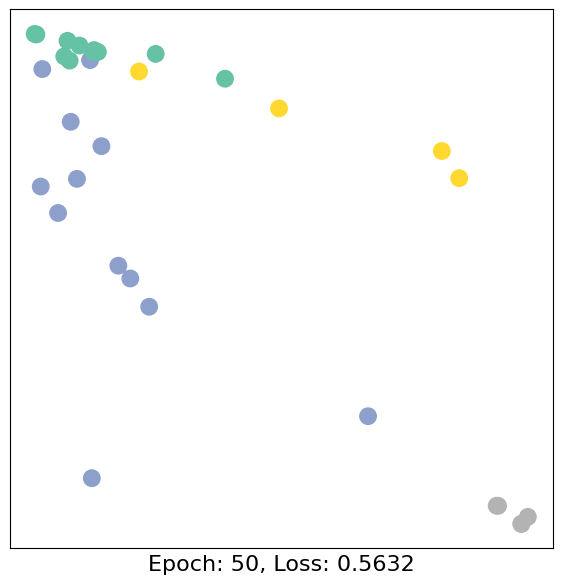

50 tensor(0.5632, grad_fn=<NllLossBackward0>)


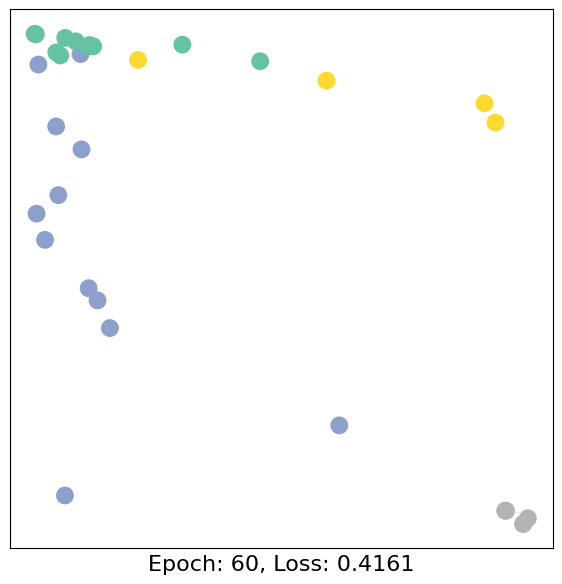

60 tensor(0.4161, grad_fn=<NllLossBackward0>)


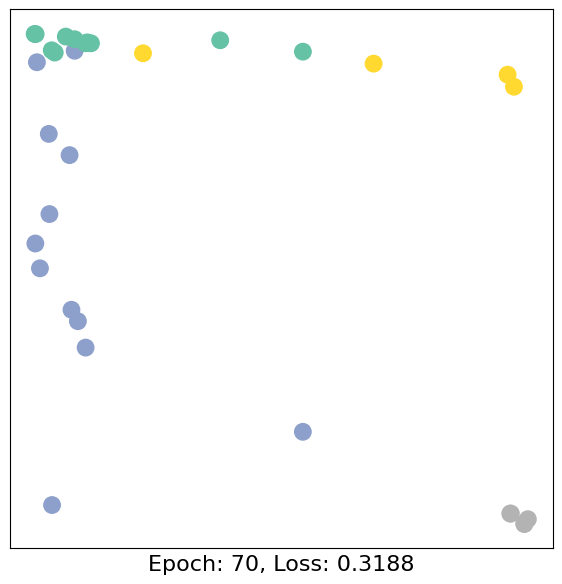

70 tensor(0.3188, grad_fn=<NllLossBackward0>)


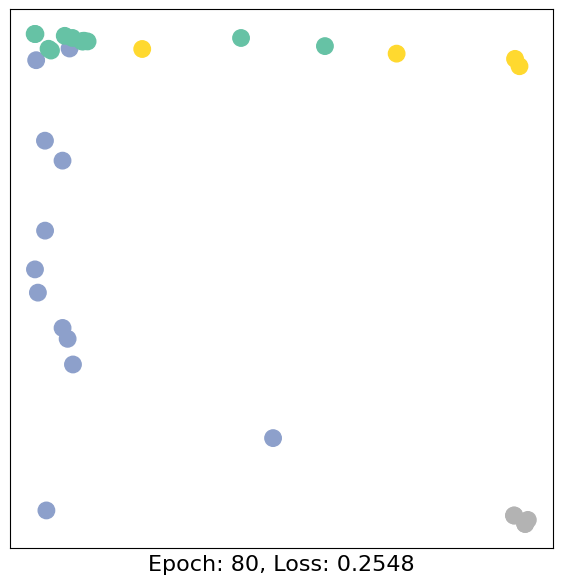

80 tensor(0.2548, grad_fn=<NllLossBackward0>)


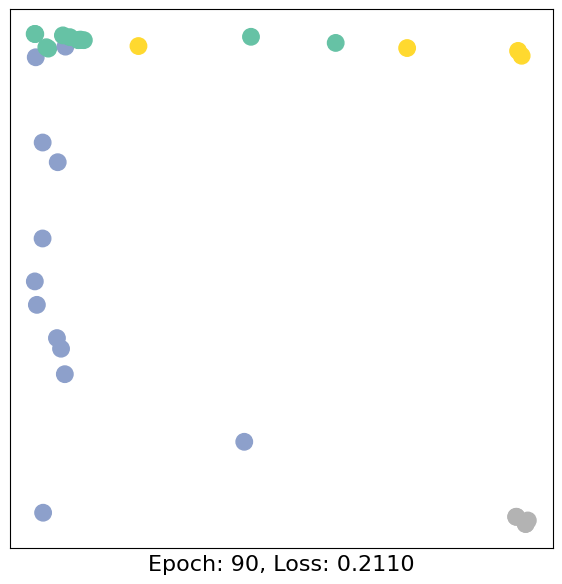

90 tensor(0.2110, grad_fn=<NllLossBackward0>)


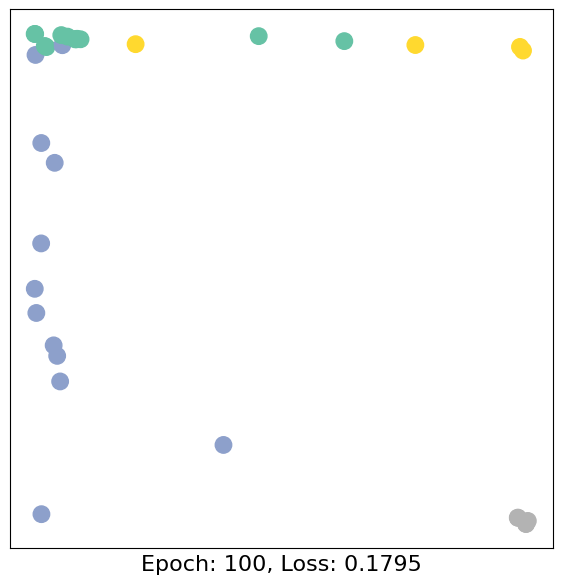

100 tensor(0.1795, grad_fn=<NllLossBackward0>)


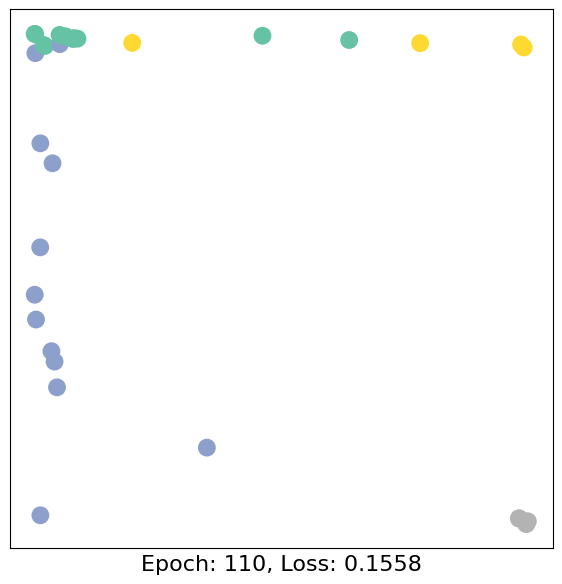

110 tensor(0.1558, grad_fn=<NllLossBackward0>)


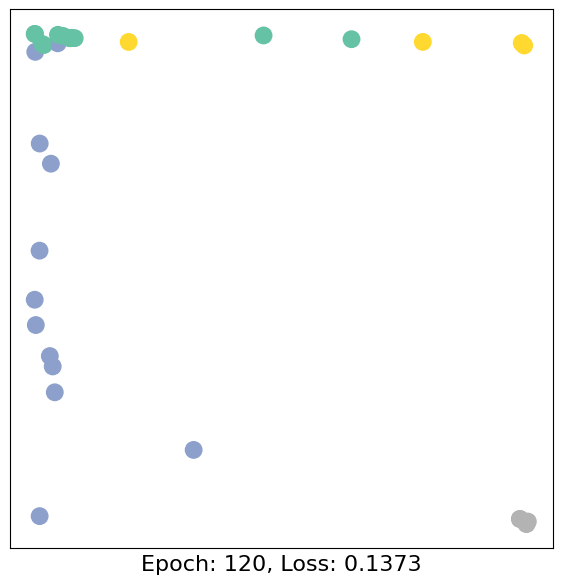

120 tensor(0.1373, grad_fn=<NllLossBackward0>)


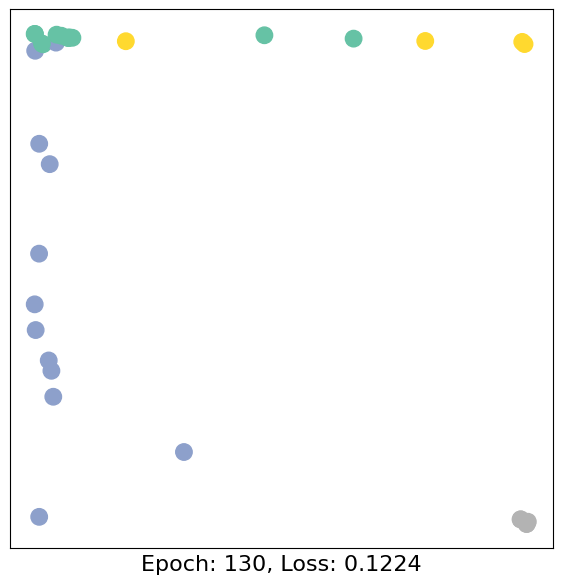

130 tensor(0.1224, grad_fn=<NllLossBackward0>)


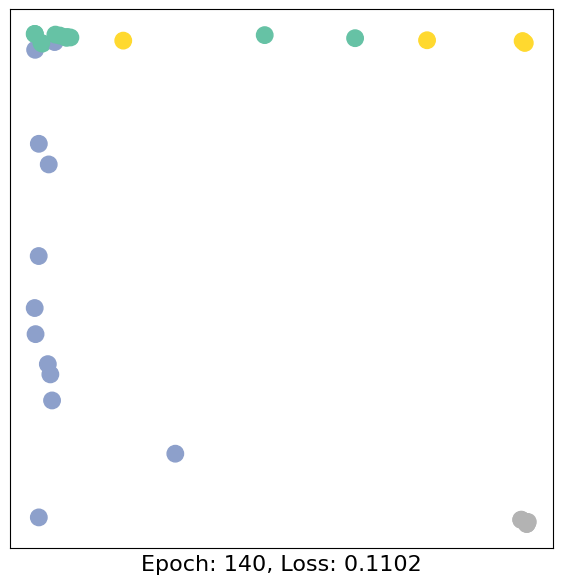

140 tensor(0.1102, grad_fn=<NllLossBackward0>)


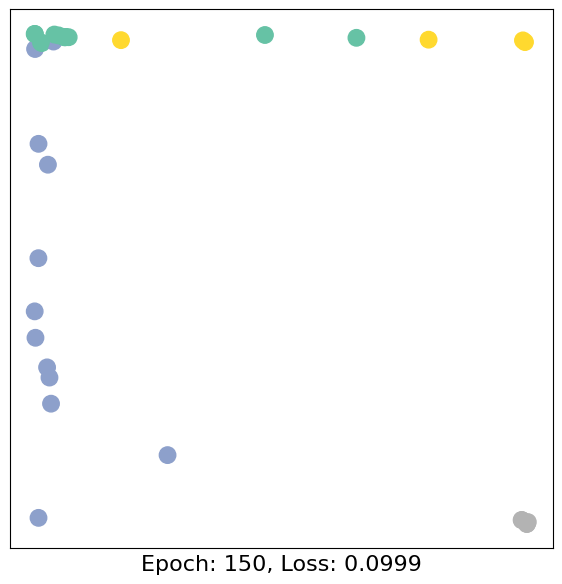

150 tensor(0.0999, grad_fn=<NllLossBackward0>)


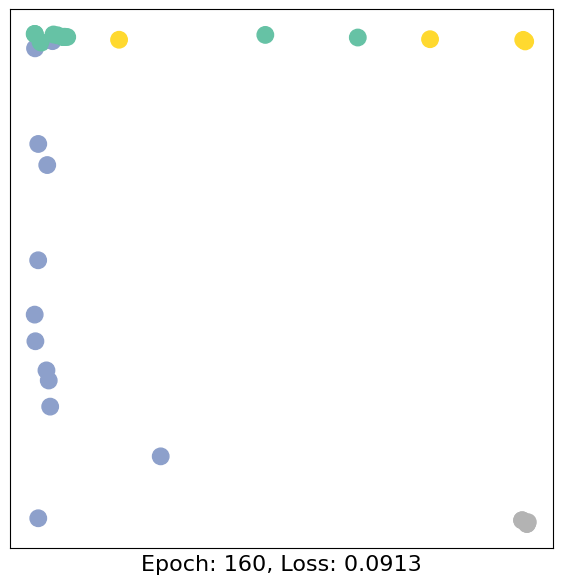

160 tensor(0.0913, grad_fn=<NllLossBackward0>)


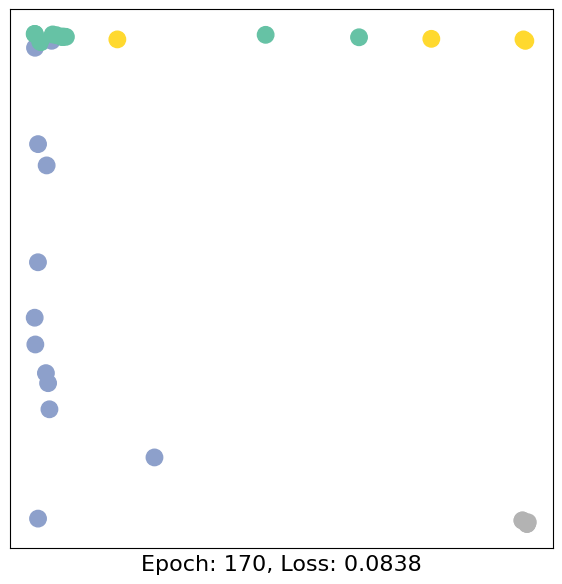

170 tensor(0.0838, grad_fn=<NllLossBackward0>)


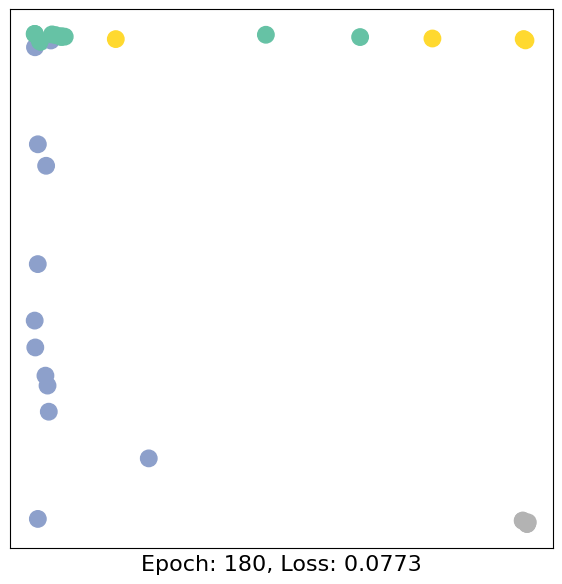

180 tensor(0.0773, grad_fn=<NllLossBackward0>)


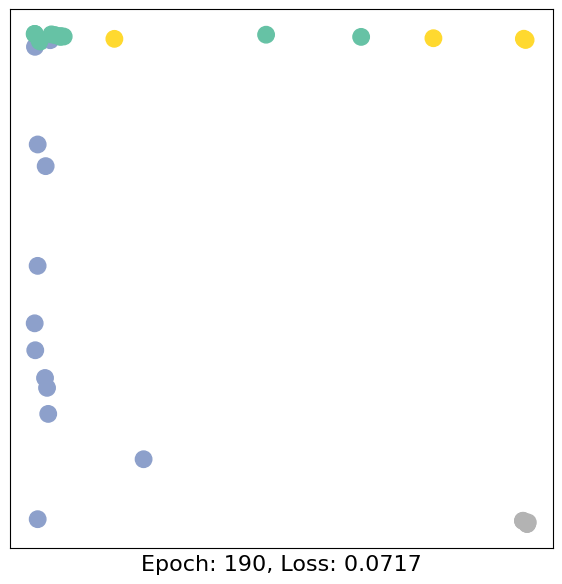

190 tensor(0.0717, grad_fn=<NllLossBackward0>)


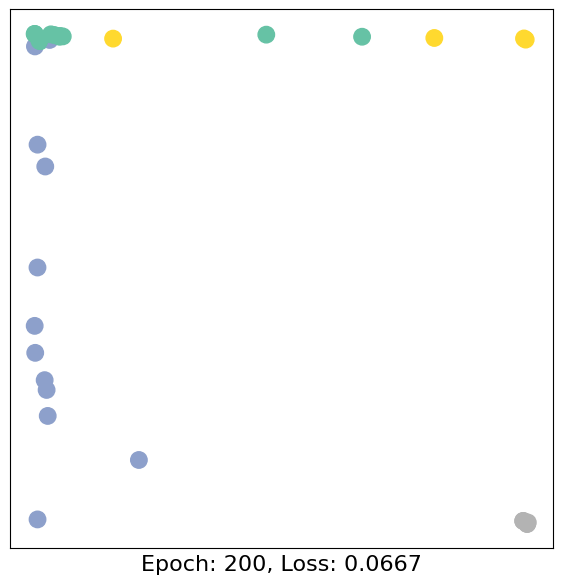

200 tensor(0.0667, grad_fn=<NllLossBackward0>)


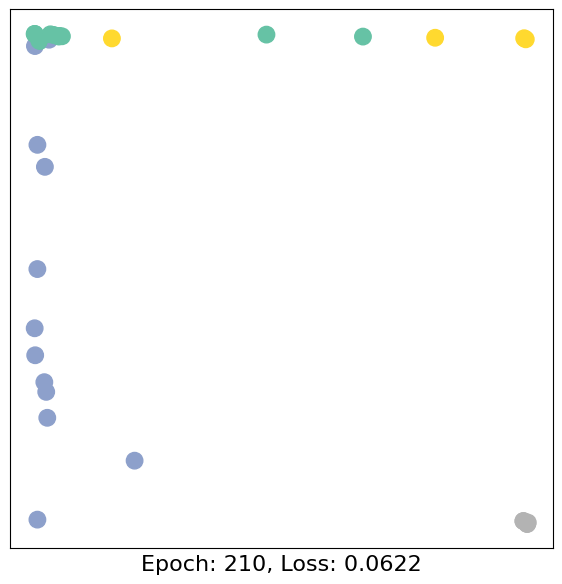

210 tensor(0.0622, grad_fn=<NllLossBackward0>)


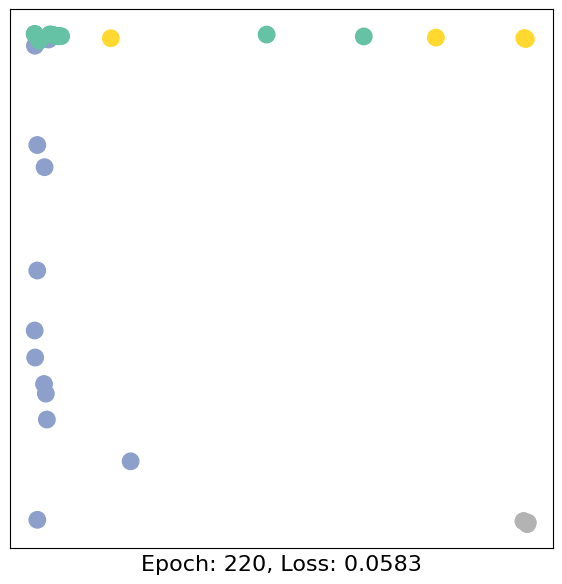

220 tensor(0.0583, grad_fn=<NllLossBackward0>)


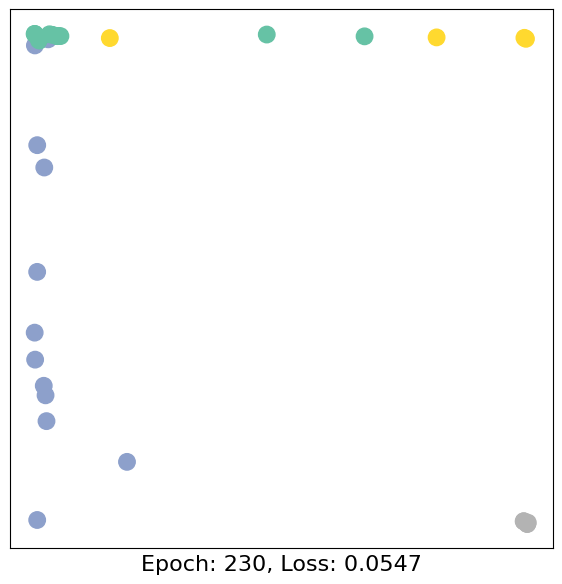

230 tensor(0.0547, grad_fn=<NllLossBackward0>)


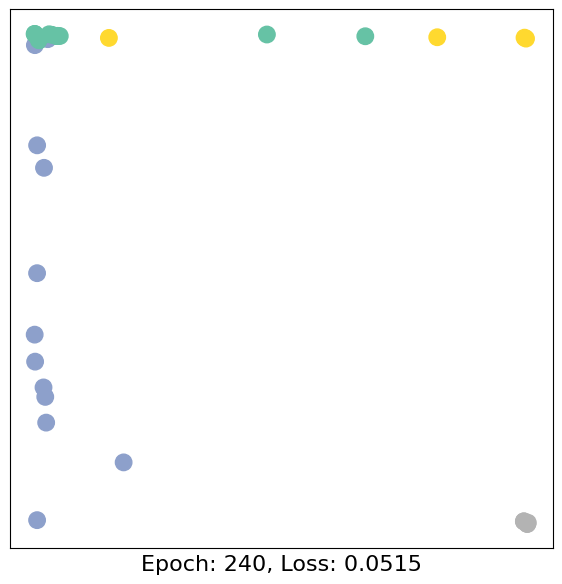

240 tensor(0.0515, grad_fn=<NllLossBackward0>)


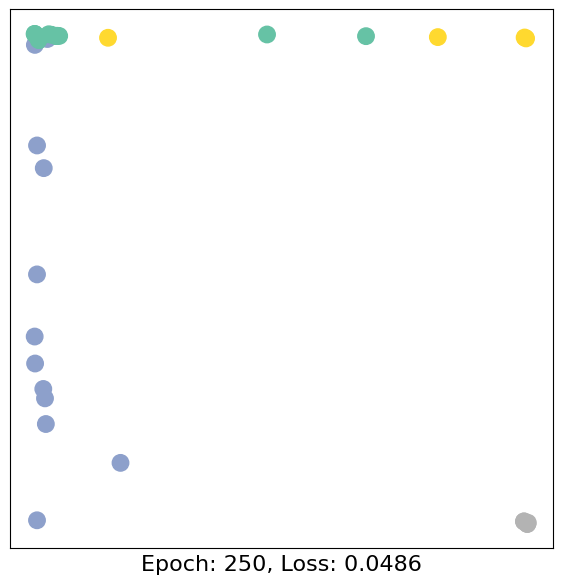

250 tensor(0.0486, grad_fn=<NllLossBackward0>)


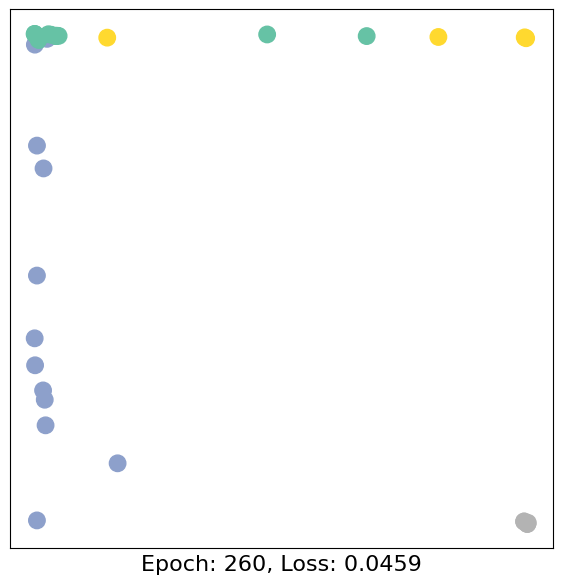

260 tensor(0.0459, grad_fn=<NllLossBackward0>)


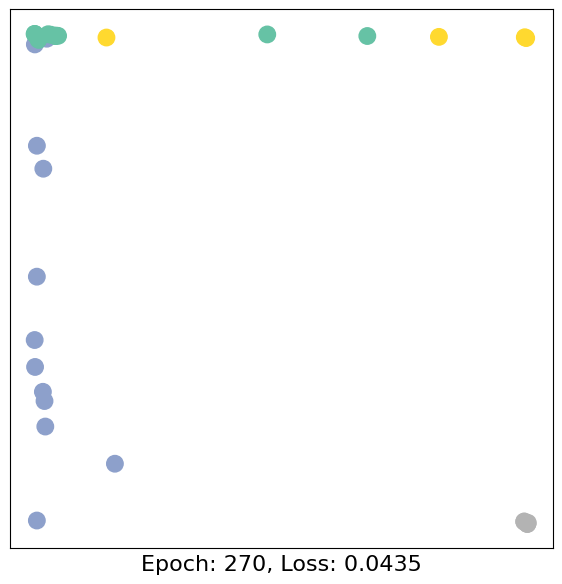

270 tensor(0.0435, grad_fn=<NllLossBackward0>)


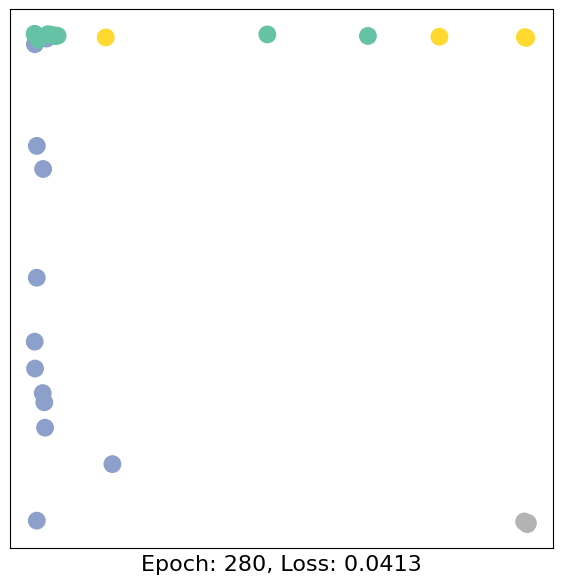

280 tensor(0.0413, grad_fn=<NllLossBackward0>)


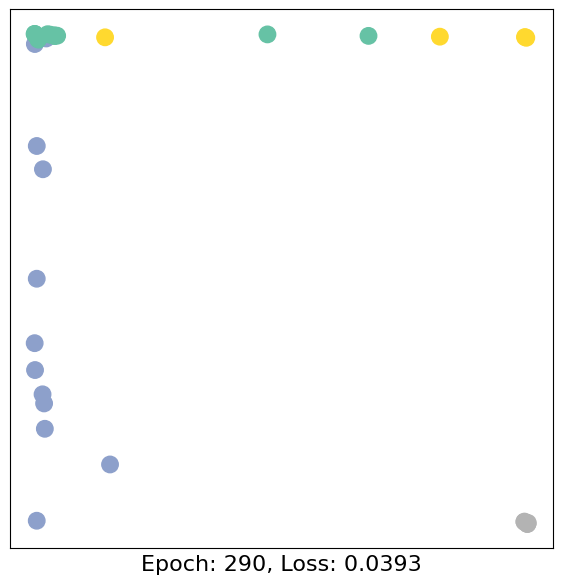

290 tensor(0.0393, grad_fn=<NllLossBackward0>)


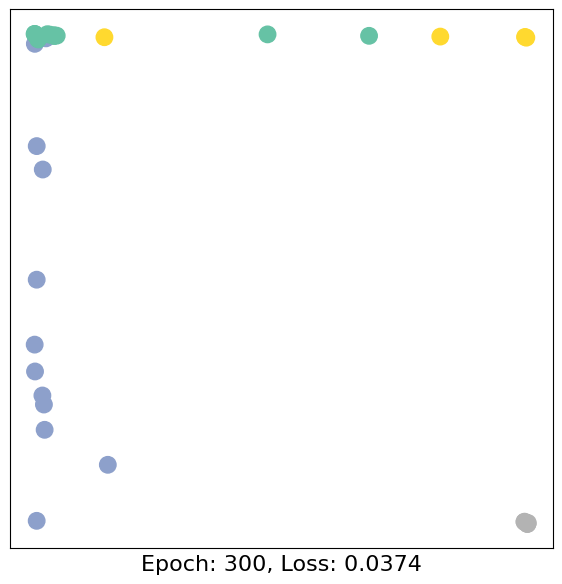

300 tensor(0.0374, grad_fn=<NllLossBackward0>)


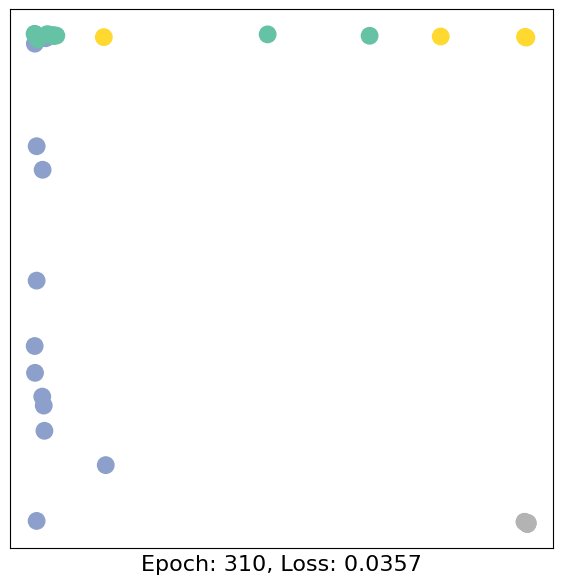

310 tensor(0.0357, grad_fn=<NllLossBackward0>)


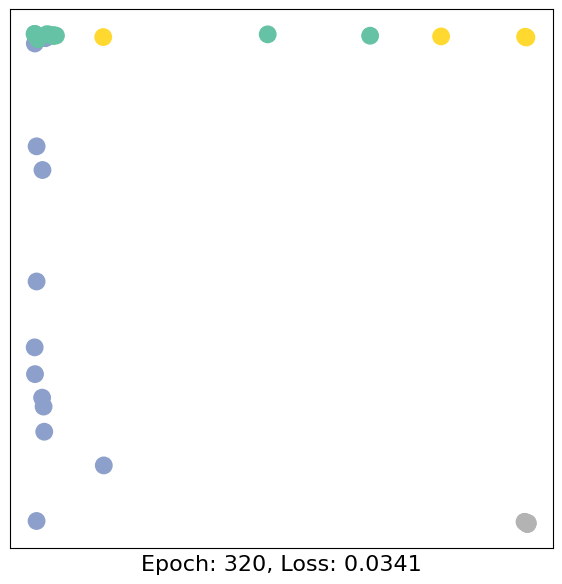

320 tensor(0.0341, grad_fn=<NllLossBackward0>)


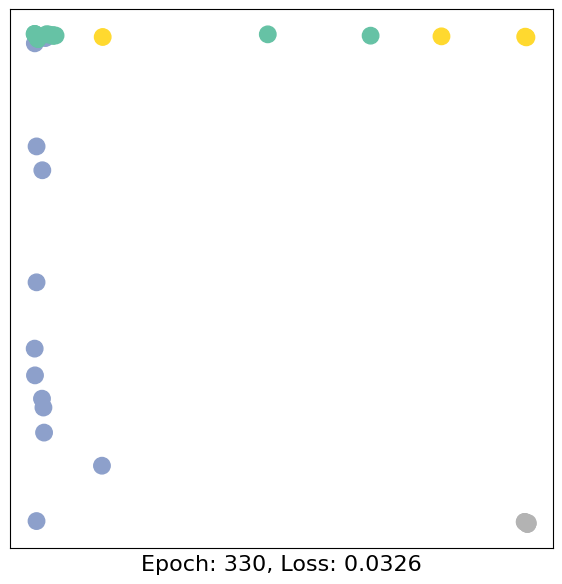

330 tensor(0.0326, grad_fn=<NllLossBackward0>)


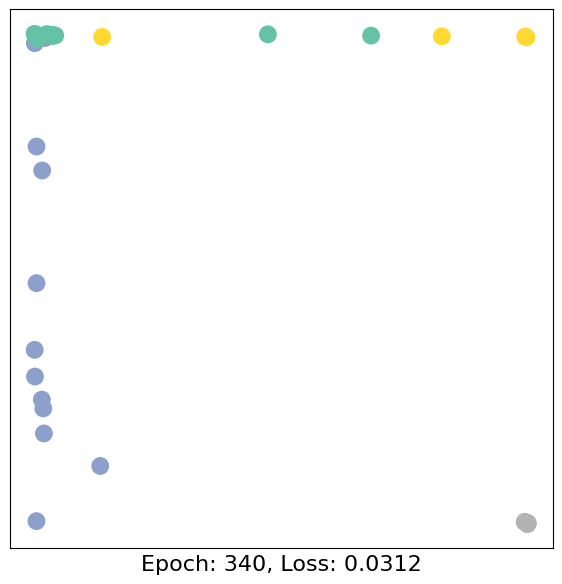

340 tensor(0.0312, grad_fn=<NllLossBackward0>)


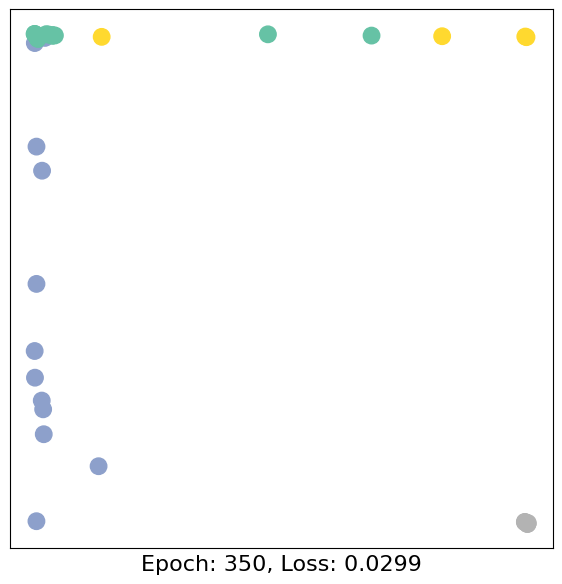

350 tensor(0.0299, grad_fn=<NllLossBackward0>)


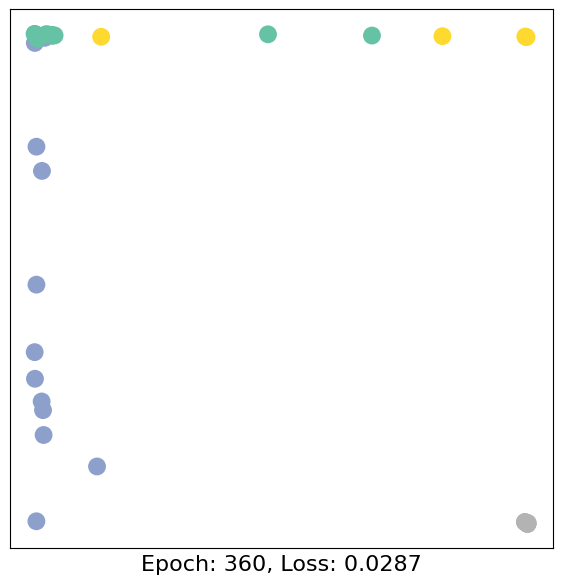

360 tensor(0.0287, grad_fn=<NllLossBackward0>)


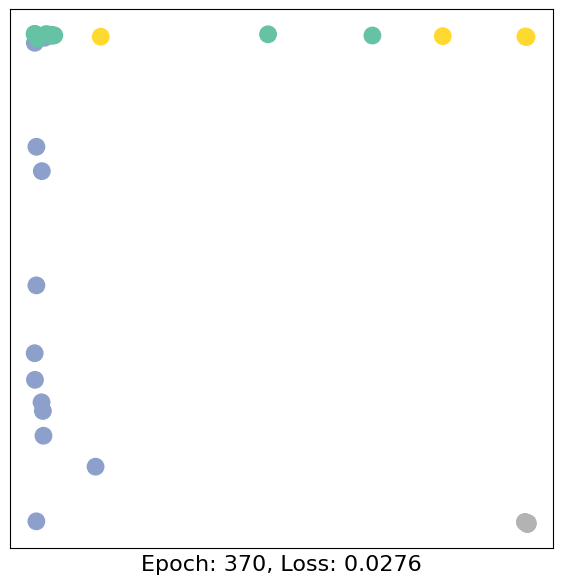

370 tensor(0.0276, grad_fn=<NllLossBackward0>)


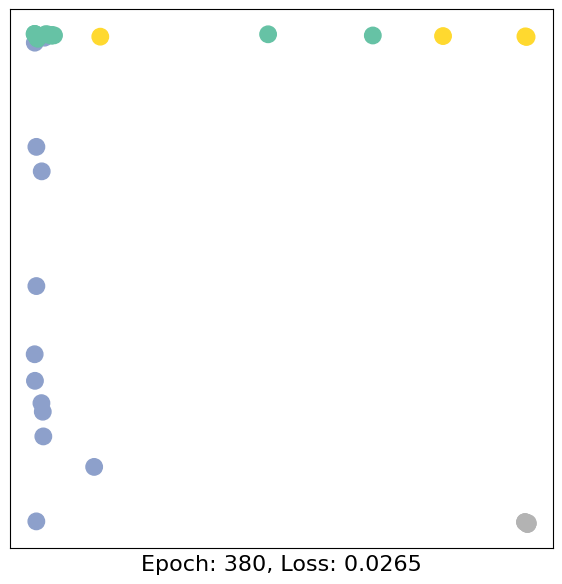

380 tensor(0.0265, grad_fn=<NllLossBackward0>)


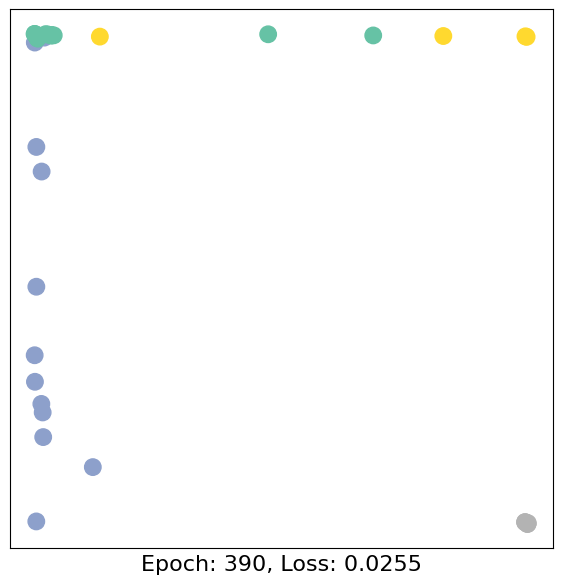

390 tensor(0.0255, grad_fn=<NllLossBackward0>)


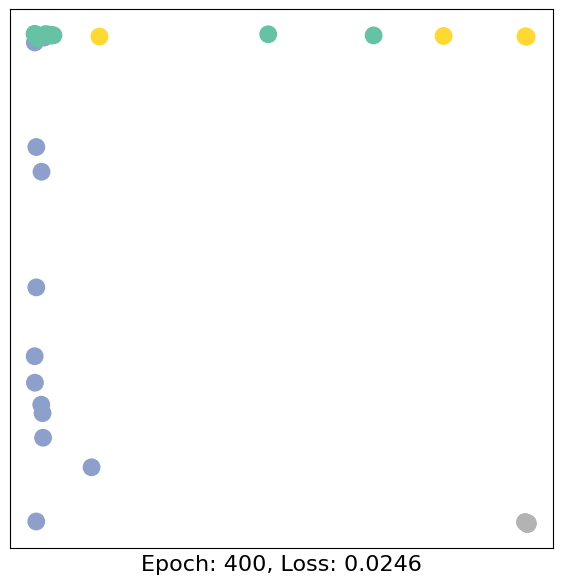

400 tensor(0.0246, grad_fn=<NllLossBackward0>)


In [24]:
'''
using GCN with tanh activation. I have to see and learn (from google) the difference
'''
import time
# from IPython.display import Javascript  # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model_tanh = GCN_tanh()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_tanh.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model_tanh(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out

for epoch in range(401):
    loss, h, out = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        print(epoch, loss)
#         visualize_graph(G, color=out.argmax(1))
        time.sleep(0.3)

In [31]:
class GCN_relu(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
#         h = F.relu(self.conv1(x, edge_index))
        h = F.leaky_relu(self.conv1(x, edge_index), negative_slope=0.01)
#         h = h.tanh()
#         h = F.relu(self.conv2(h, edge_index))
        h = F.leaky_relu(self.conv2(h, edge_index), negative_slope=0.01)
#         h = h.tanh()
#         h = F.relu(self.conv3(h, edge_index))
        h = F.leaky_relu(self.conv3(h, edge_index), negative_slope=0.01)
#         h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model_relu = GCN_relu()
print(model_relu)

GCN_relu(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


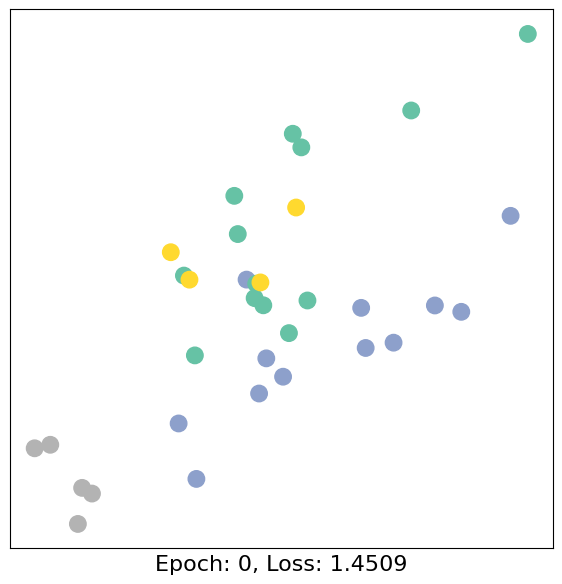

0 tensor(1.4509, grad_fn=<NllLossBackward0>)


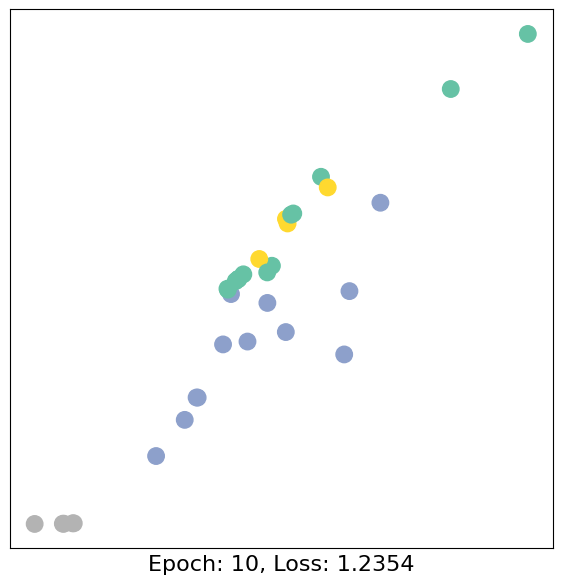

10 tensor(1.2354, grad_fn=<NllLossBackward0>)


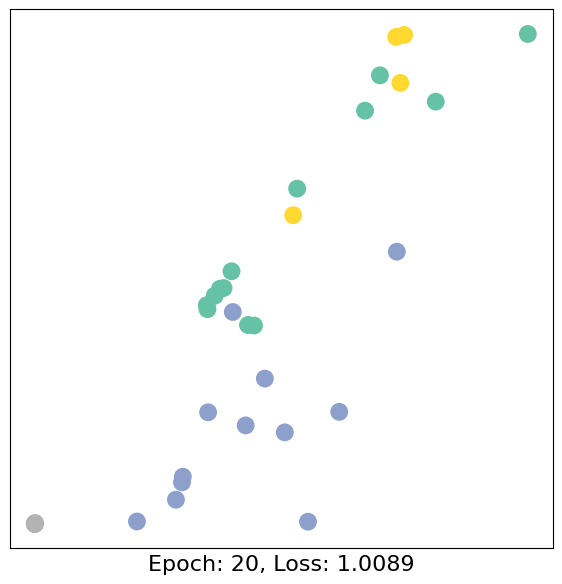

20 tensor(1.0089, grad_fn=<NllLossBackward0>)


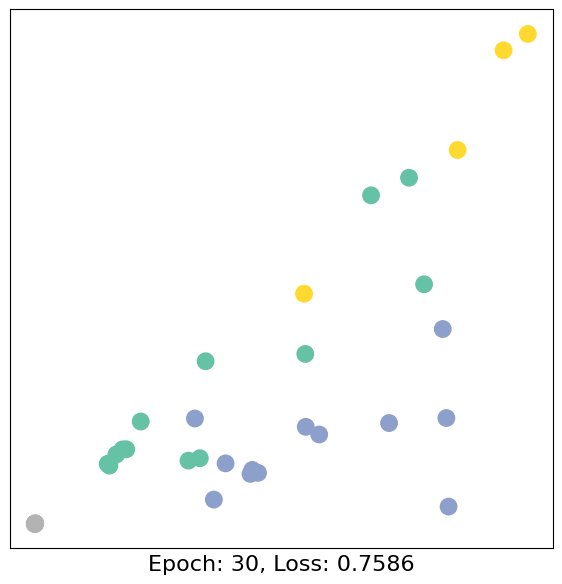

30 tensor(0.7586, grad_fn=<NllLossBackward0>)


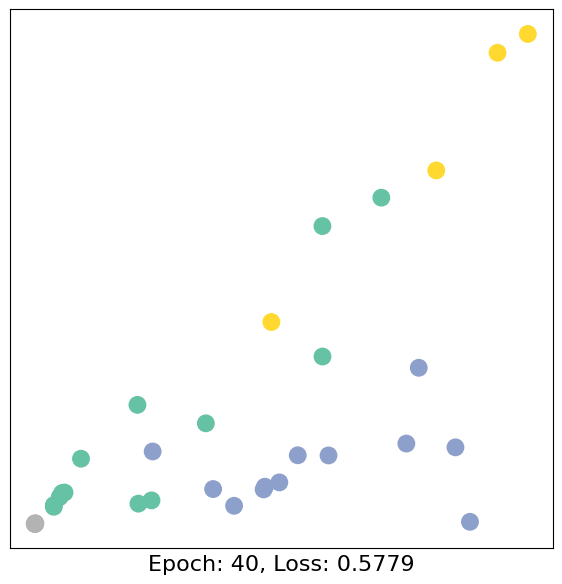

40 tensor(0.5779, grad_fn=<NllLossBackward0>)


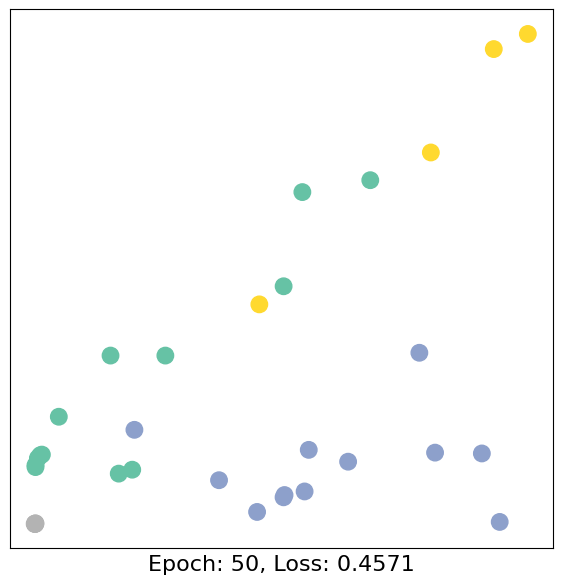

50 tensor(0.4571, grad_fn=<NllLossBackward0>)


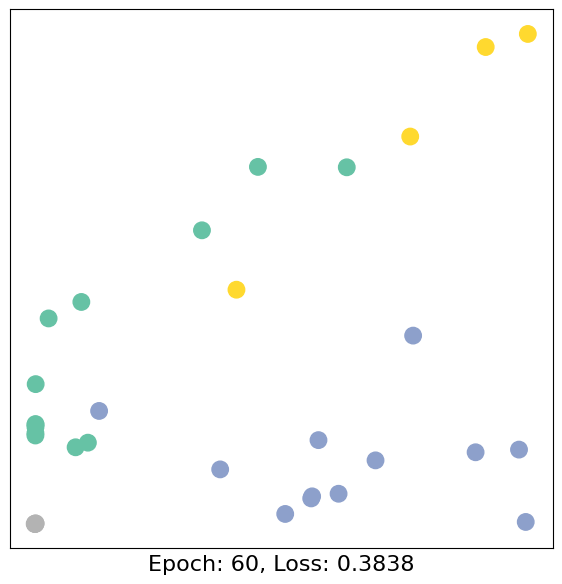

60 tensor(0.3838, grad_fn=<NllLossBackward0>)


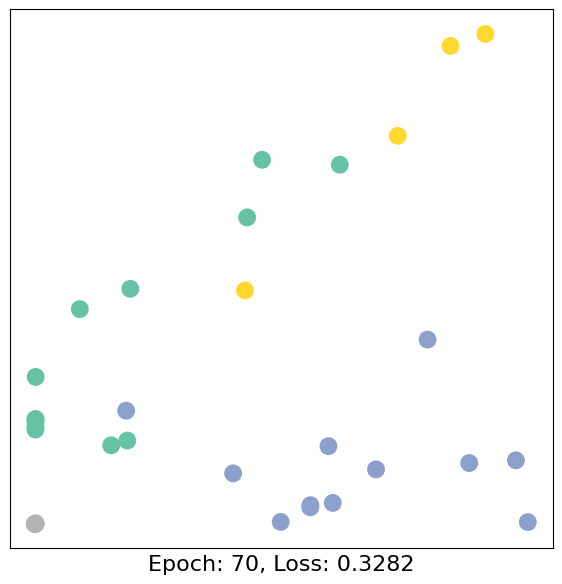

70 tensor(0.3282, grad_fn=<NllLossBackward0>)


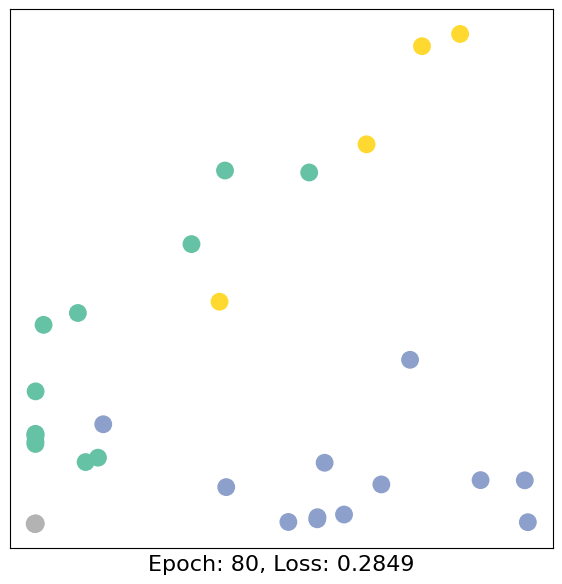

80 tensor(0.2849, grad_fn=<NllLossBackward0>)


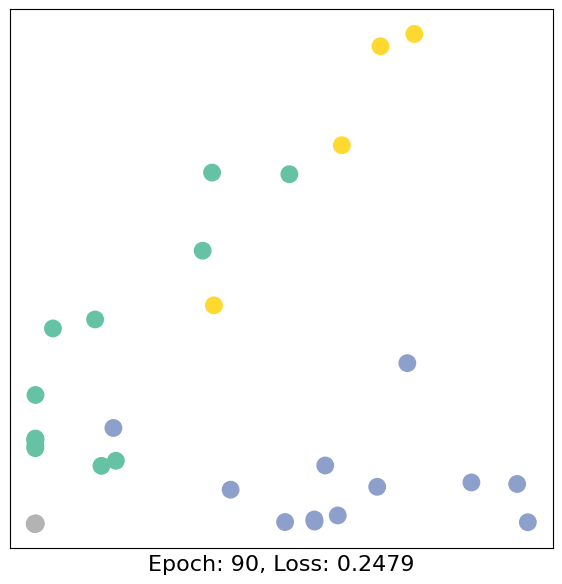

90 tensor(0.2479, grad_fn=<NllLossBackward0>)


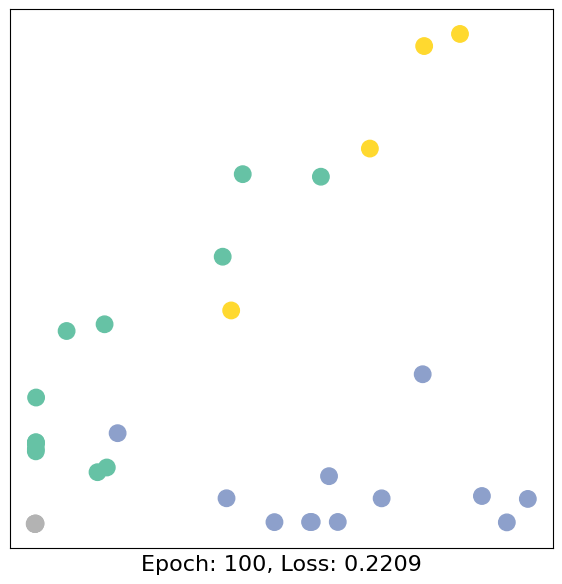

100 tensor(0.2209, grad_fn=<NllLossBackward0>)


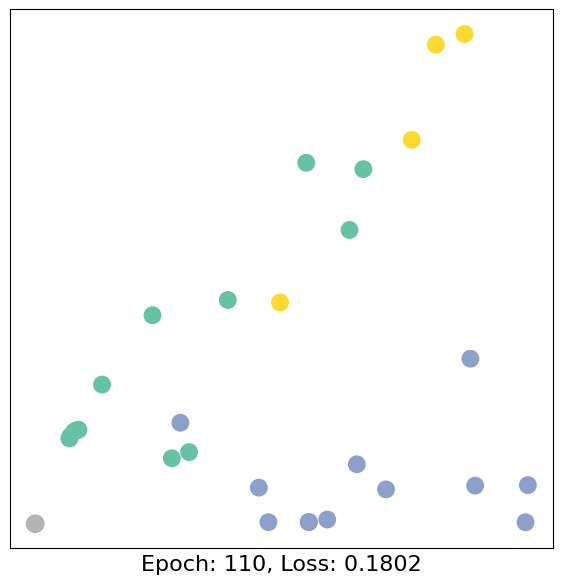

110 tensor(0.1802, grad_fn=<NllLossBackward0>)


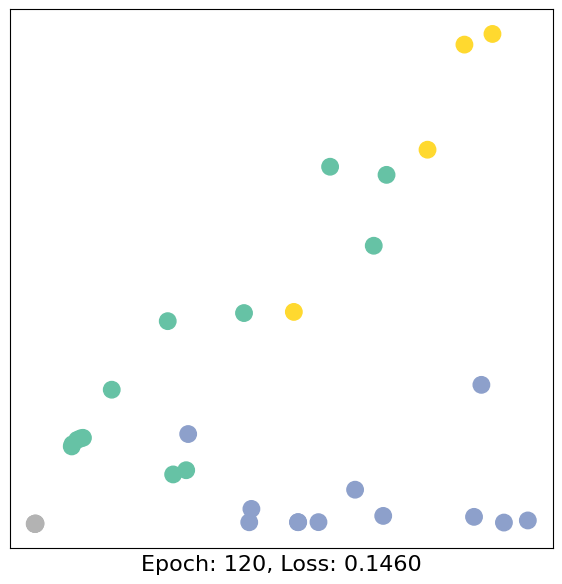

120 tensor(0.1460, grad_fn=<NllLossBackward0>)


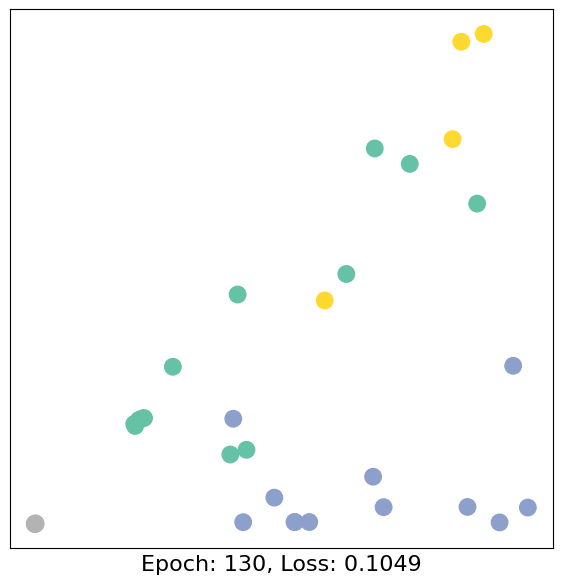

130 tensor(0.1049, grad_fn=<NllLossBackward0>)


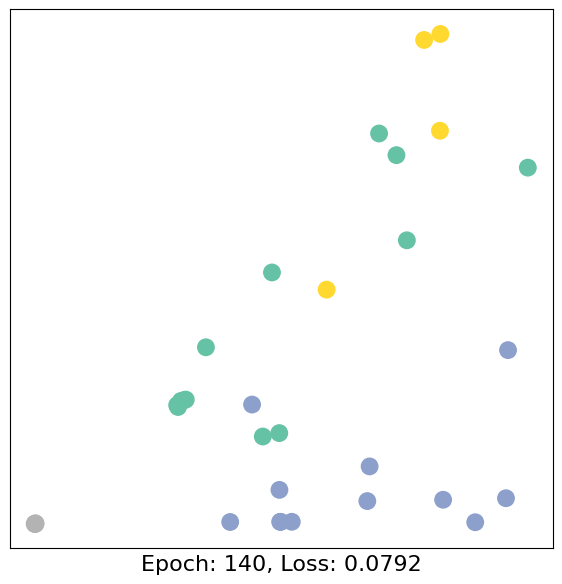

140 tensor(0.0792, grad_fn=<NllLossBackward0>)


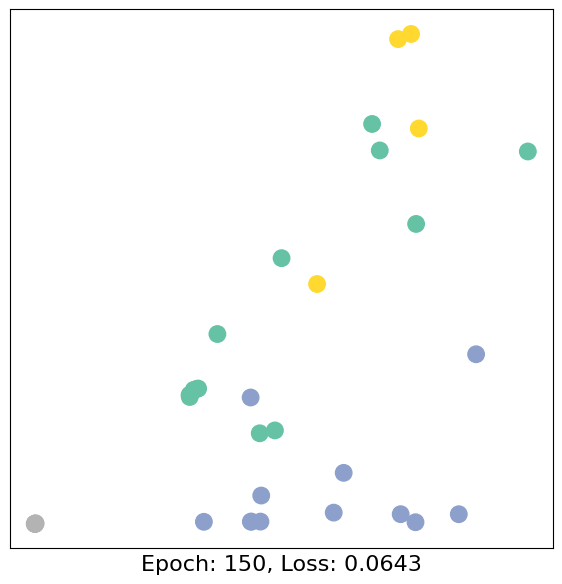

150 tensor(0.0643, grad_fn=<NllLossBackward0>)


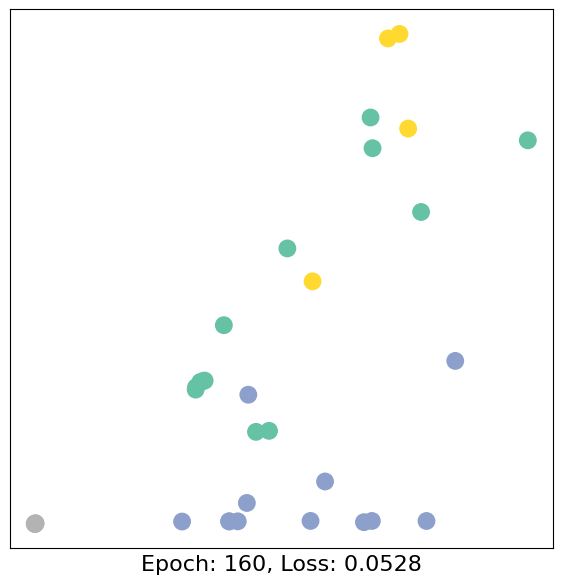

160 tensor(0.0528, grad_fn=<NllLossBackward0>)


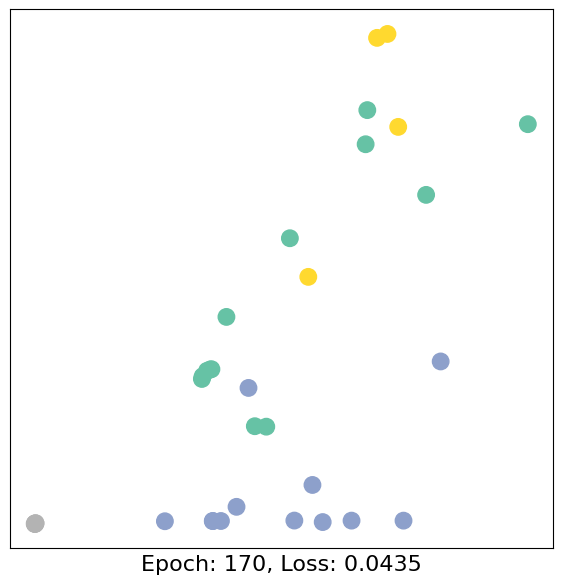

170 tensor(0.0435, grad_fn=<NllLossBackward0>)


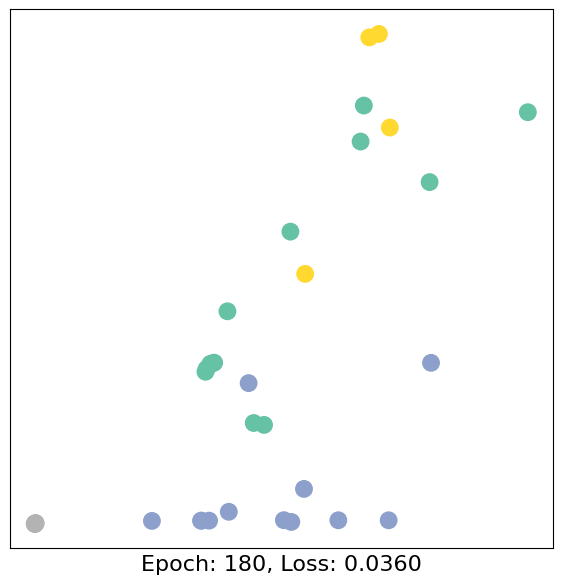

180 tensor(0.0360, grad_fn=<NllLossBackward0>)


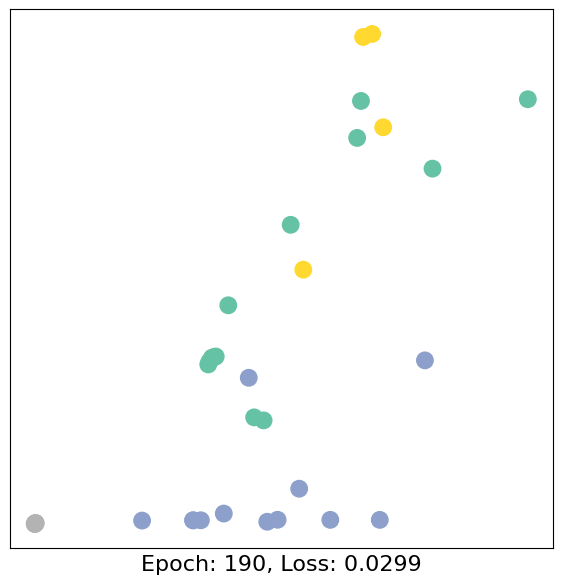

190 tensor(0.0299, grad_fn=<NllLossBackward0>)


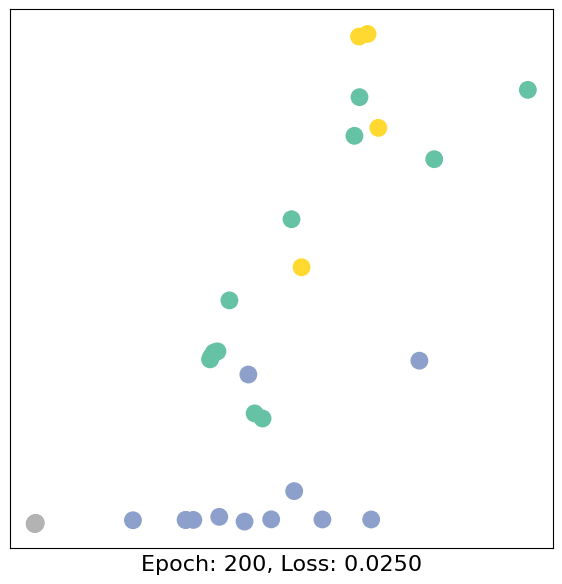

200 tensor(0.0250, grad_fn=<NllLossBackward0>)


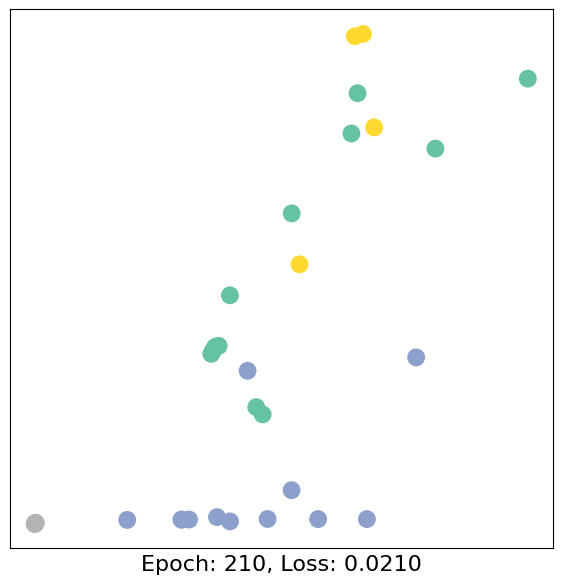

210 tensor(0.0210, grad_fn=<NllLossBackward0>)


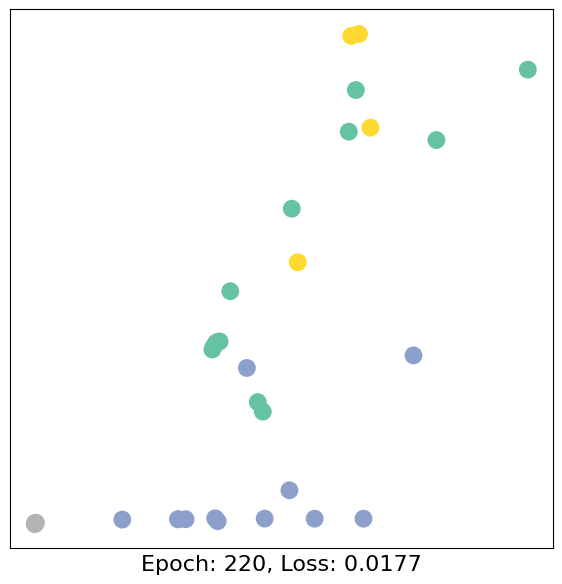

220 tensor(0.0177, grad_fn=<NllLossBackward0>)


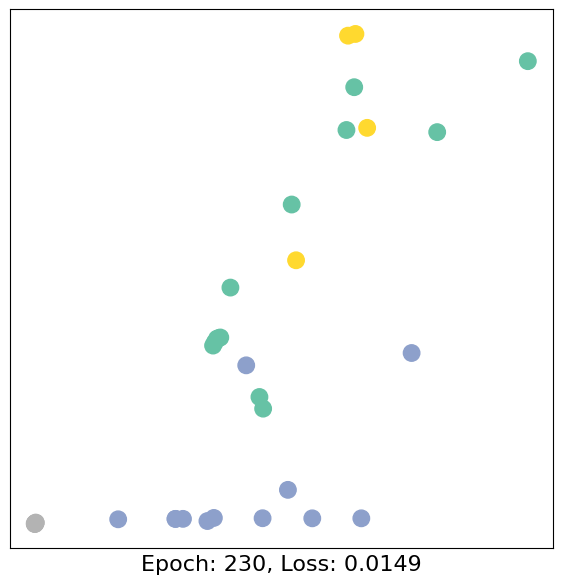

230 tensor(0.0149, grad_fn=<NllLossBackward0>)


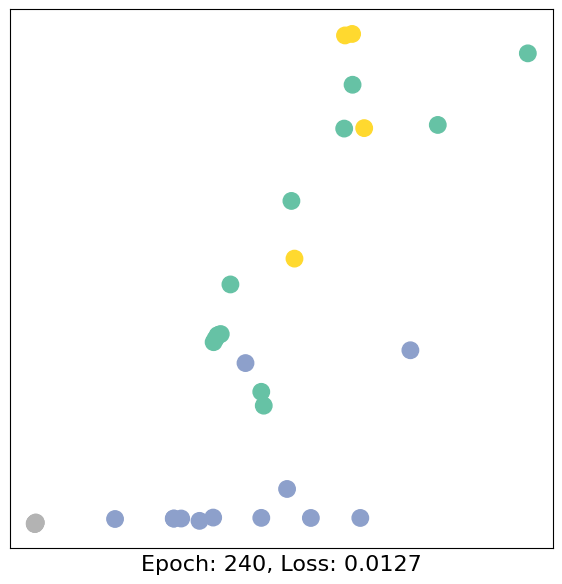

240 tensor(0.0127, grad_fn=<NllLossBackward0>)


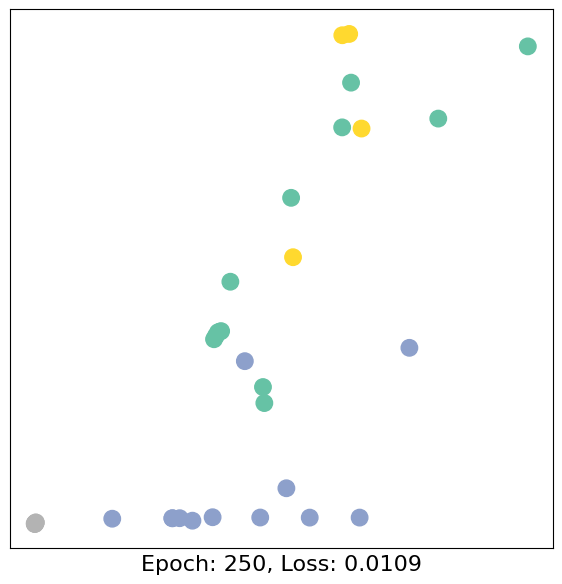

250 tensor(0.0109, grad_fn=<NllLossBackward0>)


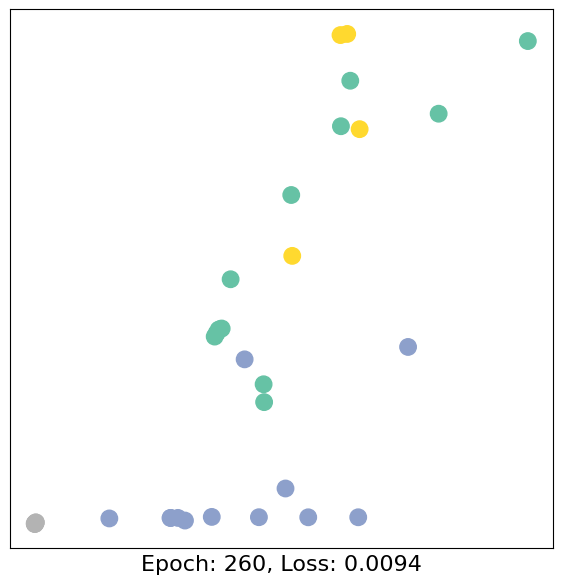

260 tensor(0.0094, grad_fn=<NllLossBackward0>)


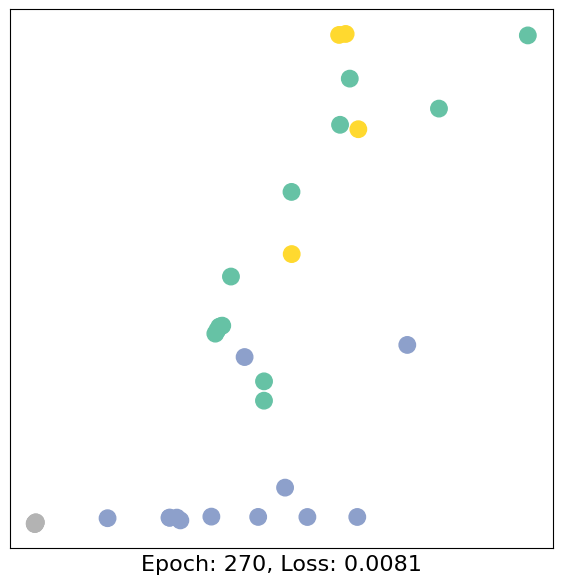

270 tensor(0.0081, grad_fn=<NllLossBackward0>)


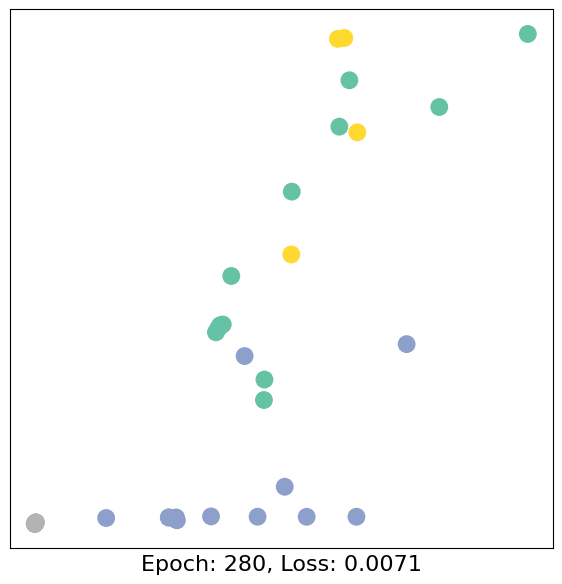

280 tensor(0.0071, grad_fn=<NllLossBackward0>)


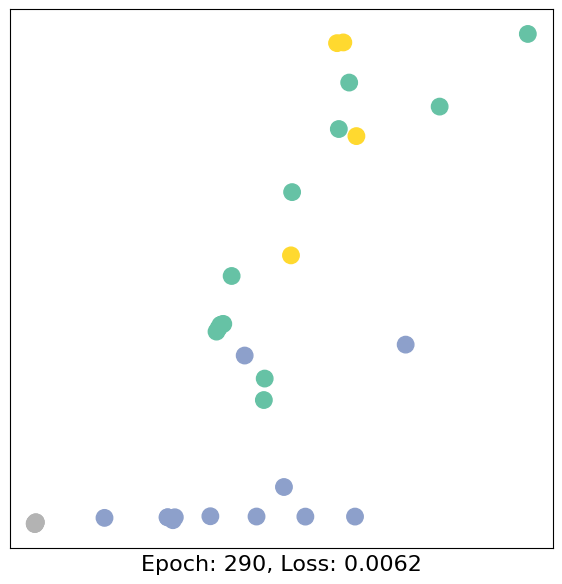

290 tensor(0.0062, grad_fn=<NllLossBackward0>)


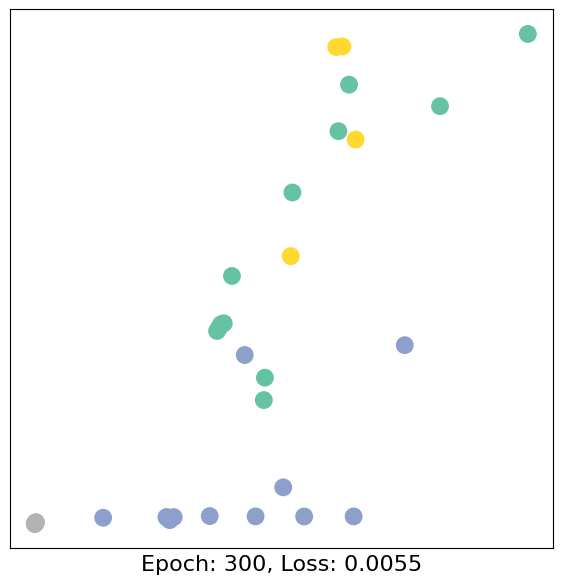

300 tensor(0.0055, grad_fn=<NllLossBackward0>)


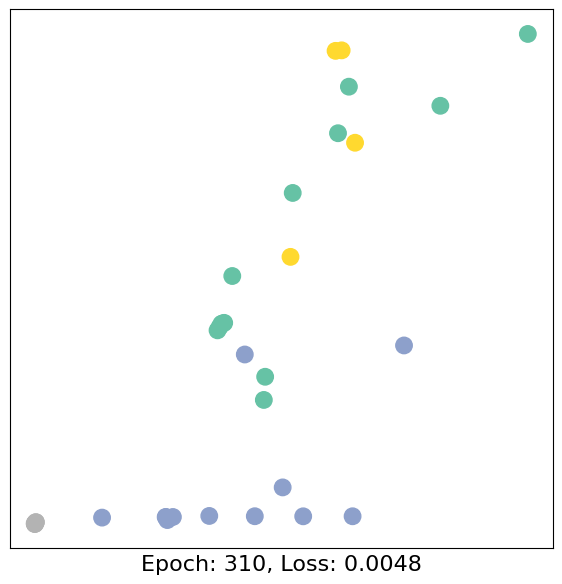

310 tensor(0.0048, grad_fn=<NllLossBackward0>)


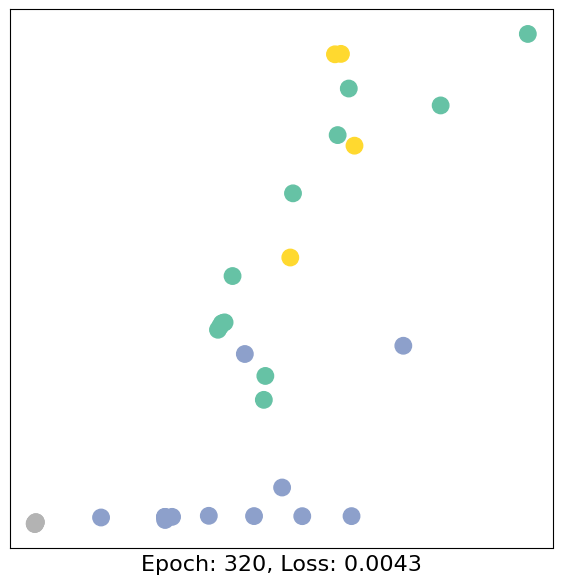

320 tensor(0.0043, grad_fn=<NllLossBackward0>)


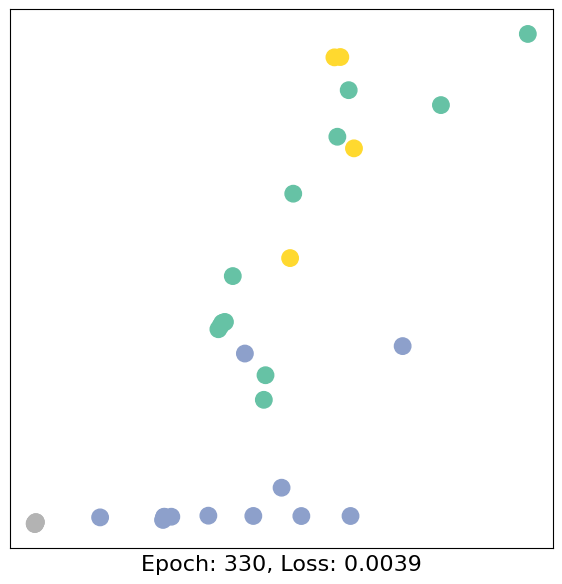

330 tensor(0.0039, grad_fn=<NllLossBackward0>)


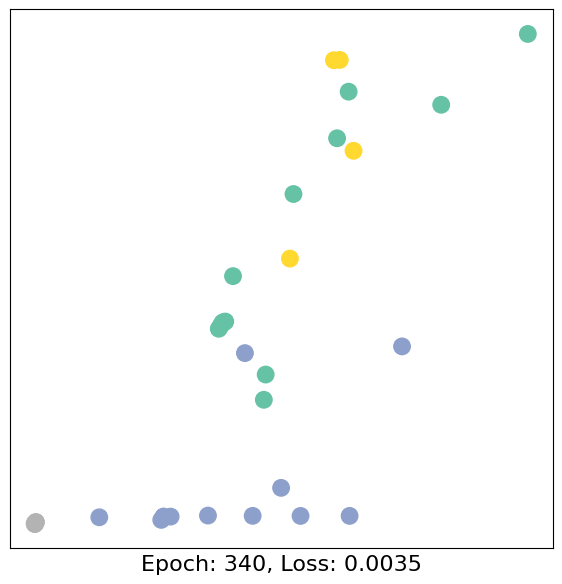

340 tensor(0.0035, grad_fn=<NllLossBackward0>)


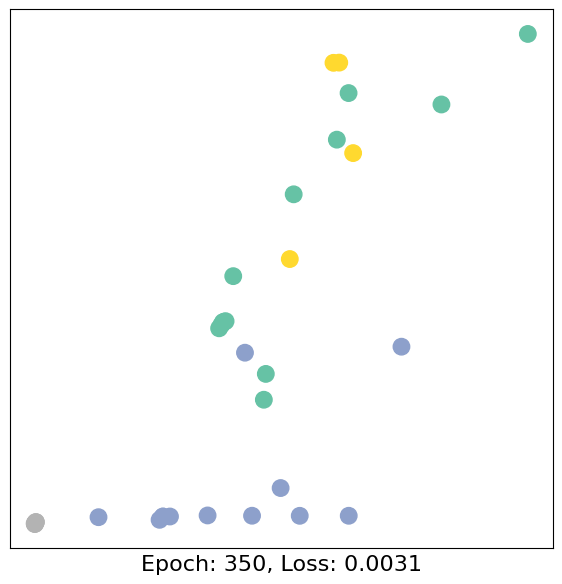

350 tensor(0.0031, grad_fn=<NllLossBackward0>)


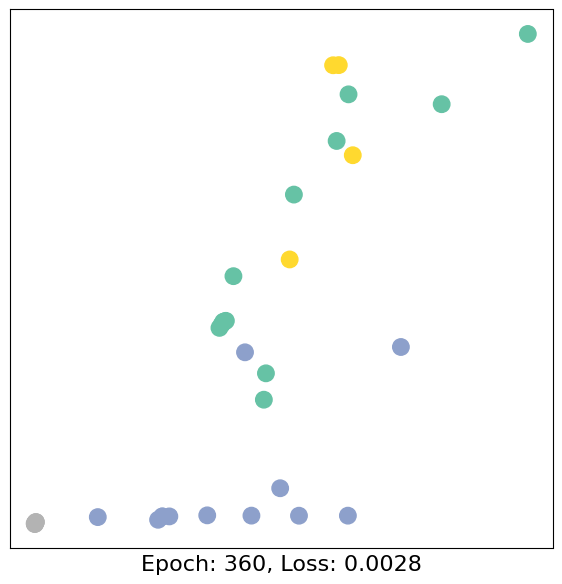

360 tensor(0.0028, grad_fn=<NllLossBackward0>)


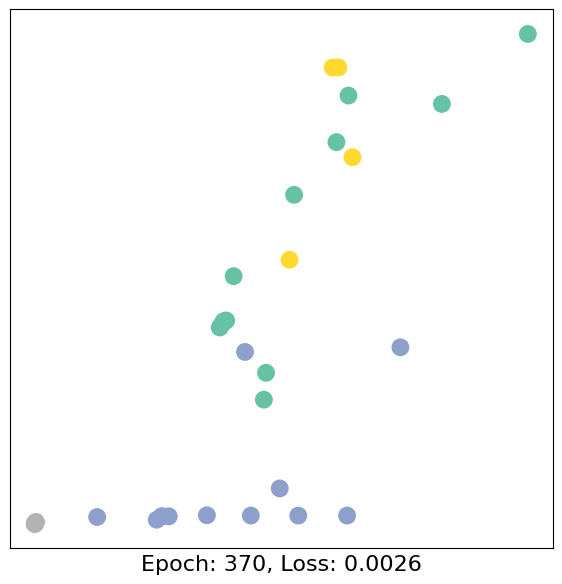

370 tensor(0.0026, grad_fn=<NllLossBackward0>)


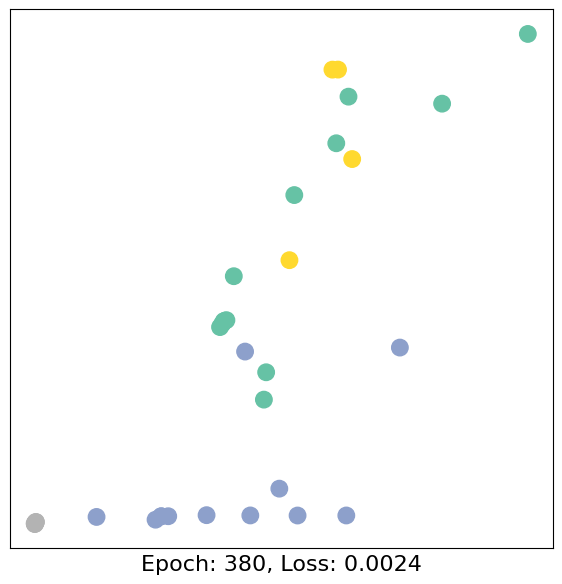

380 tensor(0.0024, grad_fn=<NllLossBackward0>)


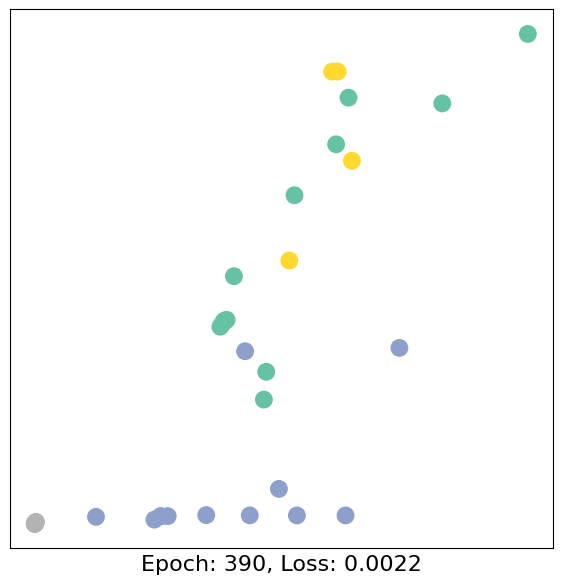

390 tensor(0.0022, grad_fn=<NllLossBackward0>)


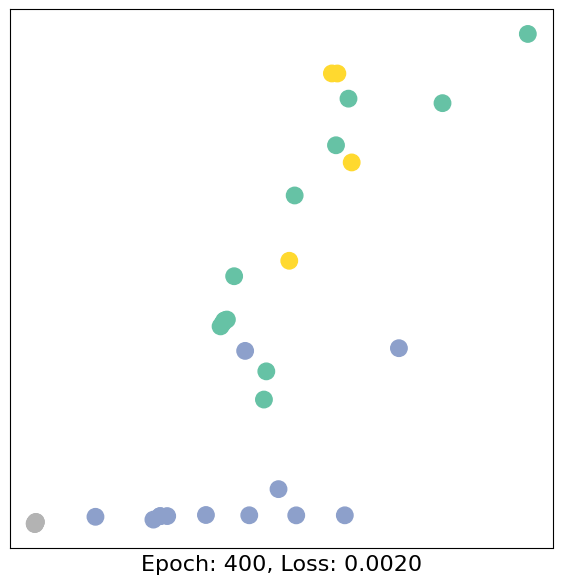

400 tensor(0.0020, grad_fn=<NllLossBackward0>)


In [32]:
'''
using GCN with ReLU activation. I have to see and learn (from google) the difference
'''
import time
# from IPython.display import Javascript  # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model_relu = GCN_relu()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_relu.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model_relu(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out

for epoch in range(401):
    loss, h, out = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        print(epoch, loss)
#         visualize_graph(G, color=out.argmax(1))
        time.sleep(0.3)